### Duration Regression

#### bank client data:
    1 - age (numeric)
    2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    5 - default: has credit in default? (categorical: 'no','yes','unknown')
    6 - housing: has housing loan? (categorical: 'no','yes','unknown')
    7 - loan: has personal loan? (categorical: 'no','yes','unknown')
    
#### related with the last contact of the current campaign:
    8 - contact: contact communication type (categorical: 'cellular','telephone') 
    9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
    11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    
#### other attributes:
    12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    14 - previous: number of contacts performed before this campaign and for this client (numeric)
    15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
    
#### social and economic context attributes
    16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
    17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
    18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
    19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
    20 - nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

- Objective: implement model to predict call duration ahead of its occurrence so it can be used by Stacking Ensembles

In [704]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [705]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn import preprocessing

In [750]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, r2_score
#from sklearn.utils.fixes import signature
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Also try ARMA models

In [832]:
data = pd.read_pickle('data/pickle_files/df_pickle_w_time_stats')
df = data.copy()

In [833]:
cat_vars = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month_last_contact', 'day_of_week_last_contact', 'poutcome']

In [834]:
df = df.drop(columns = cat_vars)

In [835]:
df.columns

Index(['cons_conf', 'ind_turnover', 'major_purch_expect',
       'major_purch_opportu', 'unempl_expect', 'inflation_delta_expect',
       'economy_expect', 'economy_past', 'financial_past',
       'savings_delta_expect', 'household_debt_ratio', 'savings_expect',
       'emplmnt_industry_index', 'railway_passengers', 'month', 'year', 'Date',
       'day', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

In [836]:
df.drop(columns = ['Date', 'month', 'day'], inplace=True)

In [837]:
df.head()

cons_conf  ind_turnover  major_purch_expect  major_purch_opportu  \
0    -28.500       113.720             -21.800              -65.100   
1    -28.500       113.720             -21.800              -65.100   
2    -28.500       113.720             -21.800              -65.100   
3    -28.500       113.720             -21.800              -65.100   
4    -28.500       113.720             -21.800              -65.100   

   unempl_expect  inflation_delta_expect  economy_expect  economy_past  \
0         48.700                  52.200         -33.300       -57.100   
1         48.700                  52.200         -33.300       -57.100   
2         48.700                  52.200         -33.300       -57.100   
3         48.700                  52.200         -33.300       -57.100   
4         48.700                  52.200         -33.300       -57.100   

   financial_past  savings_delta_expect ...  duration  campaign  pdays  \
0         -28.000               -37.800 ...       261         1    999   
1         -28.000               -37.800 ...       149         1    999   
2         -28.000               -37.800 ...       226         1    999   
3         -28.000               -37.800 ...       151         1    999   
4         -28.000               -37.800 ...       307         1    999   

   previous  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0         0         1.100          93.994        -36.400      4.857   
1         0         1.100          93.994        -36.400      4.857   
2         0         1.100          93.994        -36.400      4.857   
3         0         1.100          93.994        -36.400      4.857   
4         0         1.100          93.994        -36.400      4.857   

   nr.employed  y  
0     5191.000  0  
1     5191.000  0  
2     5191.000  0  
3     5191.000  0  
4     5191.000  0  

[5 rows x 26 columns]

In [838]:
#Checking dtypes have loaded correctly (should return empty index)
df.select_dtypes(exclude = ['float64', 'int64']).columns

df = df[df['duration']>0]

#y = df['duration']

#del df['duration']

scaler = preprocessing.StandardScaler().fit(df)
X_transformed = pd.DataFrame(scaler.transform(df), columns = df.columns)

y = X_transformed['duration']
X_transformed = X_transformed.drop(columns=['duration', 'y'])

X_transformed = np.array(X_transformed)

#X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_transformed), y, random_state = 4)

#will work with numpy arrays

#y = np.array(np.log(y))
#X = np.array(X_transformed)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


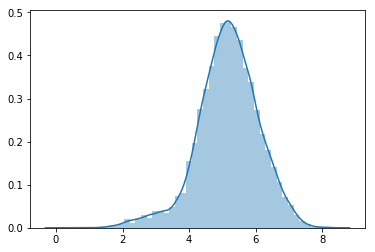

In [819]:
sns.distplot(y)

In [661]:
df_dummies = pd.DataFrame()
for col in cat_vars:
    helper = pd.get_dummies(X_transformed[col], drop_first = True)
    X_transformed = X_transformed.merge(helper, how='inner', left_index=True, right_index=True)

In [662]:
X_transformed.drop(columns = cat_vars, axis=1, inplace=True)

In [490]:
def nested_CV(X, y, estimator, param_grid, num_cv = 10):
    
    gs = GridSearchCV(estimator = estimator,
                     param_grid = param_grid,
                     scoring = 'r2',
                     cv=2)
    
    scores = cross_val_score(estimator, X, y, scoring='r2', cv = num_cv)
    #scores_recall = cross_val_score(estimator, X_transformed, y, scoring=make_scorer(report_withrecall), cv = num_cv)
    #scores_prec = cross_val_score(gs_LR, X_transformed, y, scoring=make_scorer(report_withprecision), cv = 10)
    
    #print('ML Algorithm: %s' %(estimator.__name__))
    print("Average Performance Measures Across %i Folds" %(num_cv))
    print('CV R2 : %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

In [663]:
estimator = LinearRegression()

In [846]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, test_size = 0.33, random_state = 1)

In [665]:
scores = cross_val_score(estimator, X_train, y_train, scoring='r2', cv = 10)

In [666]:
print('CV R2 : %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV R2 : 0.060 +/- 0.012


In [629]:
y_pred = cross_val_predict(estimator, X_test, y_test, cv=10)

In [667]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [668]:
r2_score(y_test, y_pred)

0.06892483319062814

In [686]:
poly = preprocessing.PolynomialFeatures(2, interaction_only=True)

In [687]:
X_poly = poly.fit_transform(X_transformed)

In [688]:
X_train, X_test, y_train, y_test = train_test_split(X_poly,y, test_size = 0.33, random_state = 1)

In [509]:
#scores = cross_val_score(estimator, X_train, y_train, scoring='r2', cv = 10)

In [553]:
print('CV R2 : %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV R2 : -0.058 +/- 0.360


In [ ]:
#y_pred = cross_val_predict(estimator, X_test, y_test, cv=10)

In [554]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [555]:
r2_score(y_test, y_pred)

-3.865218797043913

In [560]:
from sklearn.linear_model import BayesianRidge, SGDRegressor 
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

In [689]:
clf = GradientBoostingRegressor()

In [693]:
param_grid = {'learning_rate':[0.06, 0.1, 0.6], 'alpha' : [.3,.4,.5]}
              #,'max_depth':[10,20,50]}

In [694]:
clf.__class__.__name__

'GradientBoostingRegressor'

In [695]:
clf.get_params().keys()

dict_keys(['alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'presort', 'random_state', 'subsample', 'verbose', 'warm_start'])

In [696]:
gs = GridSearchCV(clf, param_grid).fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
gs.best_estimator_

In [ ]:
r2_score(y_test, gs.best_estimator_.predict(X_test))

In [676]:
clf = BayesianRidge()

In [677]:
clf.fit(X_train, y_train)
r2_score(y_test, clf.predict(X_test))

0.0686398869294349

In [678]:
clf = SGDRegressor()

In [679]:
clf.fit(X_train, y_train)
r2_score(y_test, clf.predict(X_test))

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.02947761489218781

In [680]:
clf = AdaBoostRegressor()

In [681]:
clf.fit(X_train, y_train)
r2_score(y_test, clf.predict(X_test))

0.0621986966020831

In [682]:
clf = RandomForestRegressor()

In [683]:
clf.fit(X_train, y_train)
r2_score(y_test, clf.predict(X_test))

-0.03245762495690574

In [684]:
clf = BaggingRegressor()

In [685]:
clf.fit(X_train, y_train)
r2_score(y_test, clf.predict(X_test))

-0.04096892742737279

In [449]:
from sklearn.ensemble import RandomForestRegressor

In [556]:
estimator = RandomForestRegressor()

In [557]:
estimator.fit(X_transformed,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [558]:
sorted(list(zip(X_transformed.columns, estimator.feature_importances_)), key=lambda x: x[1], reverse=True)

[('campaign', 0.23974272086908194),
 ('euribor3m', 0.19880946214058945),
 ('age', 0.1643631268392004),
 ('major_purch_expect', 0.06626848258807135),
 ('previous', 0.0639214432393961),
 ('pdays', 0.05937647242691192),
 ('major_purch_opportu', 0.03654049672468688),
 ('cons.conf.idx', 0.029359699666034817),
 ('household_debt_ratio', 0.02019599809015809),
 ('railway_passengers', 0.017336346735108022),
 ('cons.price.idx', 0.016261759042502405),
 ('ind_turnover', 0.014269111222824904),
 ('economy_expect', 0.01169213293881751),
 ('emplmnt_industry_index', 0.01128656785307992),
 ('inflation_delta_expect', 0.010825051113317354),
 ('unempl_expect', 0.009390737830366747),
 ('emp.var.rate', 0.008997181238295886),
 ('financial_past', 0.008075161907802404),
 ('savings_expect', 0.0056701880152567365),
 ('economy_past', 0.0027156280104493314),
 ('savings_delta_expect', 0.002341556225139937),
 ('nr.employed', 0.0017130385245208493),
 ('cons_conf', 0.0008476367583870502)]

In [ ]:
#Trying regularized models:
lasso = Lasso()

In [ ]:
alphas = np.logspace(-8, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [ ]:
nested_CV(X_transformed, y, lasso, param_grid)

In [822]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [823]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [824]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=1000, verbose=0)

In [825]:
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, X_transformed, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

KeyboardInterrupt: 

In [ ]:
# evaluate model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=1000, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(pipeline, X_transformed, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=500, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(pipeline, X_transformed, y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(48, input_dim=24, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=500, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(pipeline, X_transformed, y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
from keras import backend as K

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])

In [ ]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
    return model

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=1000, verbose=0)

kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, X_transformed, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

# evaluate model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=1000, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(pipeline, X_transformed, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
X_transformed.shape

Epoch 1/500
 - 3s - loss: 1.9724 - mean_squared_error: 1.9724 - mean_absolute_error: 1.0853 - mean_absolute_percentage_error: 597.8322 - cosine_proximity: 0.0909
Epoch 2/500
 - 0s - loss: 1.8921 - mean_squared_error: 1.8921 - mean_absolute_error: 1.0549 - mean_absolute_percentage_error: 573.5579 - cosine_proximity: 0.0864
Epoch 3/500
 - 0s - loss: 1.8191 - mean_squared_error: 1.8191 - mean_absolute_error: 1.0251 - mean_absolute_percentage_error: 549.7164 - cosine_proximity: 0.0864
Epoch 4/500
 - 0s - loss: 1.7528 - mean_squared_error: 1.7528 - mean_absolute_error: 0.9962 - mean_absolute_percentage_error: 526.2354 - cosine_proximity: 0.0844
Epoch 5/500
 - 0s - loss: 1.6929 - mean_squared_error: 1.6929 - mean_absolute_error: 0.9687 - mean_absolute_percentage_error: 503.3110 - cosine_proximity: 0.0827
Epoch 6/500
 - 0s - loss: 1.6413 - mean_squared_error: 1.6413 - mean_absolute_error: 0.9439 - mean_absolute_percentage_error: 482.1964 - cosine_proximity: 0.0827
Epoch 7/500
 - 0s - loss: 1.

Epoch 51/500
 - 0s - loss: 1.0605 - mean_squared_error: 1.0605 - mean_absolute_error: 0.6776 - mean_absolute_percentage_error: 173.5921 - cosine_proximity: 0.0310
Epoch 52/500
 - 0s - loss: 1.0592 - mean_squared_error: 1.0592 - mean_absolute_error: 0.6771 - mean_absolute_percentage_error: 173.0312 - cosine_proximity: 0.0257
Epoch 53/500
 - 0s - loss: 1.0579 - mean_squared_error: 1.0579 - mean_absolute_error: 0.6765 - mean_absolute_percentage_error: 172.5365 - cosine_proximity: 0.0246
Epoch 54/500
 - 0s - loss: 1.0567 - mean_squared_error: 1.0567 - mean_absolute_error: 0.6759 - mean_absolute_percentage_error: 172.1051 - cosine_proximity: 0.0237
Epoch 55/500
 - 0s - loss: 1.0556 - mean_squared_error: 1.0556 - mean_absolute_error: 0.6753 - mean_absolute_percentage_error: 171.7465 - cosine_proximity: 0.0204
Epoch 56/500
 - 0s - loss: 1.0546 - mean_squared_error: 1.0546 - mean_absolute_error: 0.6748 - mean_absolute_percentage_error: 171.4500 - cosine_proximity: 0.0179
Epoch 57/500
 - 0s - l

Epoch 101/500
 - 0s - loss: 1.0332 - mean_squared_error: 1.0332 - mean_absolute_error: 0.6640 - mean_absolute_percentage_error: 148.6505 - cosine_proximity: -3.6482e-03
Epoch 102/500
 - 0s - loss: 1.0330 - mean_squared_error: 1.0330 - mean_absolute_error: 0.6639 - mean_absolute_percentage_error: 148.3069 - cosine_proximity: -4.7476e-03
Epoch 103/500
 - 0s - loss: 1.0328 - mean_squared_error: 1.0328 - mean_absolute_error: 0.6638 - mean_absolute_percentage_error: 147.9660 - cosine_proximity: -4.4577e-03
Epoch 104/500
 - 0s - loss: 1.0327 - mean_squared_error: 1.0327 - mean_absolute_error: 0.6637 - mean_absolute_percentage_error: 147.6315 - cosine_proximity: -1.6308e-03
Epoch 105/500
 - 0s - loss: 1.0325 - mean_squared_error: 1.0325 - mean_absolute_error: 0.6636 - mean_absolute_percentage_error: 147.3040 - cosine_proximity: -1.4859e-03
Epoch 106/500
 - 0s - loss: 1.0323 - mean_squared_error: 1.0323 - mean_absolute_error: 0.6636 - mean_absolute_percentage_error: 146.9799 - cosine_proximity

Epoch 150/500
 - 0s - loss: 1.0282 - mean_squared_error: 1.0282 - mean_absolute_error: 0.6618 - mean_absolute_percentage_error: 139.3901 - cosine_proximity: -2.3086e-02
Epoch 151/500
 - 0s - loss: 1.0281 - mean_squared_error: 1.0281 - mean_absolute_error: 0.6617 - mean_absolute_percentage_error: 139.2995 - cosine_proximity: -2.3231e-02
Epoch 152/500
 - 0s - loss: 1.0281 - mean_squared_error: 1.0281 - mean_absolute_error: 0.6617 - mean_absolute_percentage_error: 139.2099 - cosine_proximity: -2.4535e-02
Epoch 153/500
 - 0s - loss: 1.0280 - mean_squared_error: 1.0280 - mean_absolute_error: 0.6617 - mean_absolute_percentage_error: 139.1218 - cosine_proximity: -2.6565e-02
Epoch 154/500
 - 0s - loss: 1.0280 - mean_squared_error: 1.0280 - mean_absolute_error: 0.6617 - mean_absolute_percentage_error: 139.0413 - cosine_proximity: -2.7217e-02
Epoch 155/500
 - 0s - loss: 1.0279 - mean_squared_error: 1.0279 - mean_absolute_error: 0.6616 - mean_absolute_percentage_error: 138.9647 - cosine_proximity

Epoch 199/500
 - 0s - loss: 1.0261 - mean_squared_error: 1.0261 - mean_absolute_error: 0.6608 - mean_absolute_percentage_error: 136.7964 - cosine_proximity: -4.2583e-02
Epoch 200/500
 - 0s - loss: 1.0261 - mean_squared_error: 1.0261 - mean_absolute_error: 0.6608 - mean_absolute_percentage_error: 136.7582 - cosine_proximity: -4.3018e-02
Epoch 201/500
 - 0s - loss: 1.0261 - mean_squared_error: 1.0261 - mean_absolute_error: 0.6608 - mean_absolute_percentage_error: 136.7200 - cosine_proximity: -4.3018e-02
Epoch 202/500
 - 0s - loss: 1.0260 - mean_squared_error: 1.0260 - mean_absolute_error: 0.6608 - mean_absolute_percentage_error: 136.6819 - cosine_proximity: -4.3308e-02
Epoch 203/500
 - 0s - loss: 1.0260 - mean_squared_error: 1.0260 - mean_absolute_error: 0.6608 - mean_absolute_percentage_error: 136.6434 - cosine_proximity: -4.3236e-02
Epoch 204/500
 - 0s - loss: 1.0260 - mean_squared_error: 1.0260 - mean_absolute_error: 0.6608 - mean_absolute_percentage_error: 136.6051 - cosine_proximity

Epoch 248/500
 - 0s - loss: 1.0247 - mean_squared_error: 1.0247 - mean_absolute_error: 0.6602 - mean_absolute_percentage_error: 135.0882 - cosine_proximity: -3.9032e-02
Epoch 249/500
 - 0s - loss: 1.0247 - mean_squared_error: 1.0247 - mean_absolute_error: 0.6602 - mean_absolute_percentage_error: 135.0622 - cosine_proximity: -3.9032e-02
Epoch 250/500
 - 0s - loss: 1.0247 - mean_squared_error: 1.0247 - mean_absolute_error: 0.6601 - mean_absolute_percentage_error: 135.0364 - cosine_proximity: -3.8887e-02
Epoch 251/500
 - 0s - loss: 1.0246 - mean_squared_error: 1.0246 - mean_absolute_error: 0.6601 - mean_absolute_percentage_error: 135.0107 - cosine_proximity: -3.9032e-02
Epoch 252/500
 - 0s - loss: 1.0246 - mean_squared_error: 1.0246 - mean_absolute_error: 0.6601 - mean_absolute_percentage_error: 134.9852 - cosine_proximity: -3.8814e-02
Epoch 253/500
 - 0s - loss: 1.0246 - mean_squared_error: 1.0246 - mean_absolute_error: 0.6601 - mean_absolute_percentage_error: 134.9599 - cosine_proximity

Epoch 297/500
 - 0s - loss: 1.0237 - mean_squared_error: 1.0237 - mean_absolute_error: 0.6596 - mean_absolute_percentage_error: 134.0098 - cosine_proximity: -3.9467e-02
Epoch 298/500
 - 0s - loss: 1.0237 - mean_squared_error: 1.0237 - mean_absolute_error: 0.6596 - mean_absolute_percentage_error: 133.9926 - cosine_proximity: -3.9032e-02
Epoch 299/500
 - 0s - loss: 1.0236 - mean_squared_error: 1.0236 - mean_absolute_error: 0.6596 - mean_absolute_percentage_error: 133.9753 - cosine_proximity: -3.9177e-02
Epoch 300/500
 - 0s - loss: 1.0236 - mean_squared_error: 1.0236 - mean_absolute_error: 0.6596 - mean_absolute_percentage_error: 133.9582 - cosine_proximity: -3.9032e-02
Epoch 301/500
 - 0s - loss: 1.0236 - mean_squared_error: 1.0236 - mean_absolute_error: 0.6596 - mean_absolute_percentage_error: 133.9414 - cosine_proximity: -3.8669e-02
Epoch 302/500
 - 0s - loss: 1.0236 - mean_squared_error: 1.0236 - mean_absolute_error: 0.6596 - mean_absolute_percentage_error: 133.9252 - cosine_proximity

Epoch 346/500
 - 0s - loss: 1.0229 - mean_squared_error: 1.0229 - mean_absolute_error: 0.6592 - mean_absolute_percentage_error: 133.4469 - cosine_proximity: -4.8382e-02
Epoch 347/500
 - 0s - loss: 1.0229 - mean_squared_error: 1.0229 - mean_absolute_error: 0.6592 - mean_absolute_percentage_error: 133.4385 - cosine_proximity: -4.8599e-02
Epoch 348/500
 - 0s - loss: 1.0229 - mean_squared_error: 1.0229 - mean_absolute_error: 0.6592 - mean_absolute_percentage_error: 133.4303 - cosine_proximity: -4.8962e-02
Epoch 349/500
 - 0s - loss: 1.0229 - mean_squared_error: 1.0229 - mean_absolute_error: 0.6592 - mean_absolute_percentage_error: 133.4229 - cosine_proximity: -4.8817e-02
Epoch 350/500
 - 0s - loss: 1.0229 - mean_squared_error: 1.0229 - mean_absolute_error: 0.6592 - mean_absolute_percentage_error: 133.4156 - cosine_proximity: -4.8599e-02
Epoch 351/500
 - 0s - loss: 1.0228 - mean_squared_error: 1.0228 - mean_absolute_error: 0.6592 - mean_absolute_percentage_error: 133.4081 - cosine_proximity

Epoch 395/500
 - 0s - loss: 1.0223 - mean_squared_error: 1.0223 - mean_absolute_error: 0.6589 - mean_absolute_percentage_error: 133.2476 - cosine_proximity: -5.7297e-02
Epoch 396/500
 - 0s - loss: 1.0223 - mean_squared_error: 1.0223 - mean_absolute_error: 0.6589 - mean_absolute_percentage_error: 133.2464 - cosine_proximity: -5.8094e-02
Epoch 397/500
 - 0s - loss: 1.0223 - mean_squared_error: 1.0223 - mean_absolute_error: 0.6589 - mean_absolute_percentage_error: 133.2451 - cosine_proximity: -5.9254e-02
Epoch 398/500
 - 0s - loss: 1.0223 - mean_squared_error: 1.0223 - mean_absolute_error: 0.6589 - mean_absolute_percentage_error: 133.2437 - cosine_proximity: -5.9254e-02
Epoch 399/500
 - 0s - loss: 1.0223 - mean_squared_error: 1.0223 - mean_absolute_error: 0.6589 - mean_absolute_percentage_error: 133.2423 - cosine_proximity: -5.9399e-02
Epoch 400/500
 - 0s - loss: 1.0223 - mean_squared_error: 1.0223 - mean_absolute_error: 0.6589 - mean_absolute_percentage_error: 133.2409 - cosine_proximity

Epoch 444/500
 - 0s - loss: 1.0219 - mean_squared_error: 1.0219 - mean_absolute_error: 0.6586 - mean_absolute_percentage_error: 133.2317 - cosine_proximity: -6.1429e-02
Epoch 445/500
 - 0s - loss: 1.0219 - mean_squared_error: 1.0219 - mean_absolute_error: 0.6586 - mean_absolute_percentage_error: 133.2320 - cosine_proximity: -6.1211e-02
Epoch 446/500
 - 0s - loss: 1.0219 - mean_squared_error: 1.0219 - mean_absolute_error: 0.6586 - mean_absolute_percentage_error: 133.2323 - cosine_proximity: -6.1139e-02
Epoch 447/500
 - 0s - loss: 1.0219 - mean_squared_error: 1.0219 - mean_absolute_error: 0.6586 - mean_absolute_percentage_error: 133.2325 - cosine_proximity: -6.1139e-02
Epoch 448/500
 - 0s - loss: 1.0219 - mean_squared_error: 1.0219 - mean_absolute_error: 0.6586 - mean_absolute_percentage_error: 133.2327 - cosine_proximity: -6.1356e-02
Epoch 449/500
 - 0s - loss: 1.0219 - mean_squared_error: 1.0219 - mean_absolute_error: 0.6586 - mean_absolute_percentage_error: 133.2329 - cosine_proximity

Epoch 493/500
 - 0s - loss: 1.0216 - mean_squared_error: 1.0216 - mean_absolute_error: 0.6584 - mean_absolute_percentage_error: 133.2389 - cosine_proximity: -6.7082e-02
Epoch 494/500
 - 0s - loss: 1.0216 - mean_squared_error: 1.0216 - mean_absolute_error: 0.6584 - mean_absolute_percentage_error: 133.2387 - cosine_proximity: -6.7082e-02
Epoch 495/500
 - 0s - loss: 1.0216 - mean_squared_error: 1.0216 - mean_absolute_error: 0.6584 - mean_absolute_percentage_error: 133.2386 - cosine_proximity: -6.7155e-02
Epoch 496/500
 - 0s - loss: 1.0216 - mean_squared_error: 1.0216 - mean_absolute_error: 0.6584 - mean_absolute_percentage_error: 133.2384 - cosine_proximity: -6.7372e-02
Epoch 497/500
 - 0s - loss: 1.0216 - mean_squared_error: 1.0216 - mean_absolute_error: 0.6584 - mean_absolute_percentage_error: 133.2383 - cosine_proximity: -6.7662e-02
Epoch 498/500
 - 0s - loss: 1.0216 - mean_squared_error: 1.0216 - mean_absolute_error: 0.6584 - mean_absolute_percentage_error: 133.2380 - cosine_proximity

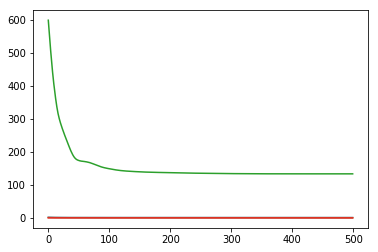

In [847]:
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# prepare sequence
#X = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# create model
model = Sequential()
model.add(Dense(24, input_dim=24))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
#model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])

# train model
history = model.fit(X_train, y_train, epochs=500, batch_size=len(X_transformed), verbose=2)
# plot metrics
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['mean_absolute_error'])
pyplot.plot(history.history['mean_absolute_percentage_error'])
pyplot.plot(history.history['cosine_proximity'])
pyplot.show()

In [853]:
#r2_score(y_test, model.predict(X_test))